# CAISO Electricity Demand Forecasting with LSTM

In [2]:
# Import required packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/caiso-electricity.csv")

# Prepare timestamp
df['timestamp'] = pd.to_datetime(df['UTC Timestamp (Interval Ending)'], errors='coerce')
df.set_index('timestamp', inplace=True)

# Display sample data
df.head()

,UTC Timestamp (Interval Ending),2021-01-01 00:00:00,Local Timestamp Pacific Time (Interval Ending),2021-01-01,Hour Number,NP-15 LMP,SP-15 LMP,ZP-26 LMP,NP-15 (Congestion),SP-15 (Congestion),ZP-26 (Congestion),NP-15 (Energy),SP-15 (Energy),ZP-26 (Energy),NP-15 (Loss),SP-15 (Loss),ZP-26 (Loss)
timestamp,,,,,,,,,,,,,,,,,
2021-01-01 08:15:00,2021-01-01 08:15:00,2021-01-01 00:15:00,2021-01-01 00:15:00,2021-01-01,1,33.22903,32.77646,33.12662,0.0,0.0,0.0,33.03412,33.03412,33.03412,0.19490,-0.25767,0.09250
2021-01-01 08:30:00,2021-01-01 08:30:00,2021-01-01 00:30:00,2021-01-01 00:30:00,2021-01-01,1,31.34914,30.77073,31.05371,0.0,0.0,0.0,31.09725,31.09725,31.09725,0.25189,-0.32652,-0.04354
2021-01-01 08:45:00,2021-01-01 08:45:00,2021-01-01 00:45:00,2021-01-01 00:45:00,2021-01-01,1,33.00641,32.52800,32.77703,0.0,0.0,0.0,32.76720,32.76720,32.76720,0.23920,-0.23920,0.00983
2021-01-01 09:00:00,2021-01-01 09:00:00,2021-01-01 01:00:00,2021-01-01 01:00:00,2021-01-01,1,29.76901,29.18473,29.48572,0.0,0.0,0.0,29.50933,29.50933,29.50933,0.25968,-0.32460,-0.02361
2021-01-01 09:15:00,2021-01-01 09:15:00,2021-01-01 01:15:00,2021-01-01 01:15:00,2021-01-01,2,30.77407,30.17173,30.45465,0.0,0.0,0.0,30.42119,30.42119,30.42119,0.35289,-0.24945,0.03346


## Model Definition

In [4]:
class LMP_LSTM_Multistep(nn.Module):
    """LSTM for multi-step electricity price forecasting"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, pred_len=16):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Data Preparation

In [5]:
def create_multistep_sequences(data, seq_length, pred_length):
    """Create input-output sequences for training"""
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+pred_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Parameters
zones = ['SP-15 LMP', 'NP-15 LMP', 'ZP26 LMP', 'PGE-TDLMP', 'SCE-TDLMP']
SEQ_LEN = 24   # 6 hours of history (15-min intervals)
PRED_LEN = 16  # 4 hours forecast
EPOCHS = 10

## Training Pipeline

In [6]:
all_results = []

for zone in zones:
    if zone not in df.columns:
        print(f"Skipping {zone} - not found")
        continue

    print(f"\nProcessing {zone}")

    # 1. Prepare data
    zone_data = df[[zone]].dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(zone_data)

    # 2. Create sequences
    X, y = create_multistep_sequences(data_scaled, SEQ_LEN, PRED_LEN)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.squeeze(), dtype=torch.float32)

    # 3. Create DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 4. Train model
    model = LMP_LSTM_Multistep(pred_len=PRED_LEN)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(EPOCHS):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

    # 5. Make predictions
    model.eval()
    with torch.no_grad():
        input_seq = torch.tensor(data_scaled[-SEQ_LEN:], dtype=torch.float32).unsqueeze(0)
        pred_scaled = model(input_seq).numpy().flatten()
        pred_actual = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # 6. Store results
    future_times = pd.date_range(start=zone_data.index[-1], periods=PRED_LEN + 1, freq='15T')[1:]
    actual_vals = zone_data[-PRED_LEN:].values.flatten()

    result_df = pd.DataFrame({
        "Zone": [zone] * len(future_times),
        "Timestamp": future_times,
        "Actual LMP": actual_vals,
        "Predicted LMP": pred_actual,
        "Error": np.abs(pred_actual - actual_vals)
    })
    all_results.append(result_df)

# Combine results
final_results = pd.concat(all_results, ignore_index=True)
final_results.tail(50)


Processing SP-15 LMP
Epoch 1/10, Loss: 0.0002
Epoch 2/10, Loss: 0.0013
Epoch 3/10, Loss: 0.0001
Epoch 4/10, Loss: 0.0002
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0001
Epoch 7/10, Loss: 0.0001
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0299

Processing NP-15 LMP


<ipython-input-6-0b7683fe135f>:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_times = pd.date_range(start=zone_data.index[-1], periods=PRED_LEN + 1, freq='15T')[1:]


Epoch 1/10, Loss: 0.0003
Epoch 2/10, Loss: 0.0741
Epoch 3/10, Loss: 0.0006
Epoch 4/10, Loss: 0.0004
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0001
Epoch 7/10, Loss: 0.0017
Epoch 8/10, Loss: 0.0003
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0001
Skipping ZP26 LMP - not found
Skipping PGE-TDLMP - not found
Skipping SCE-TDLMP - not found


<ipython-input-6-0b7683fe135f>:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_times = pd.date_range(start=zone_data.index[-1], periods=PRED_LEN + 1, freq='15T')[1:]


,Zone,Timestamp,Actual LMP,Predicted LMP,Error
0,SP-15 LMP,2021-04-01 07:15:00,50.64625,75.826515,25.180265
1,SP-15 LMP,2021-04-01 07:30:00,48.76045,78.432190,29.671740
2,SP-15 LMP,2021-04-01 07:45:00,48.00254,77.955887,29.953347
3,SP-15 LMP,2021-04-01 08:00:00,46.06476,77.707008,31.642248
4,SP-15 LMP,2021-04-01 08:15:00,51.01534,80.071037,29.055697
5,SP-15 LMP,2021-04-01 08:30:00,46.17429,76.609718,30.435428
6,SP-15 LMP,2021-04-01 08:45:00,42.67530,77.789040,35.113740
7,SP-15 LMP,2021-04-01 09:00:00,36.63598,70.320374,33.684394
8,SP-15 LMP,2021-04-01 09:15:00,45.82193,71.252998,25.431068
9,SP-15 LMP,2021-04-01 09:30:00,37.58567,68.025887,30.440217


## Visualization

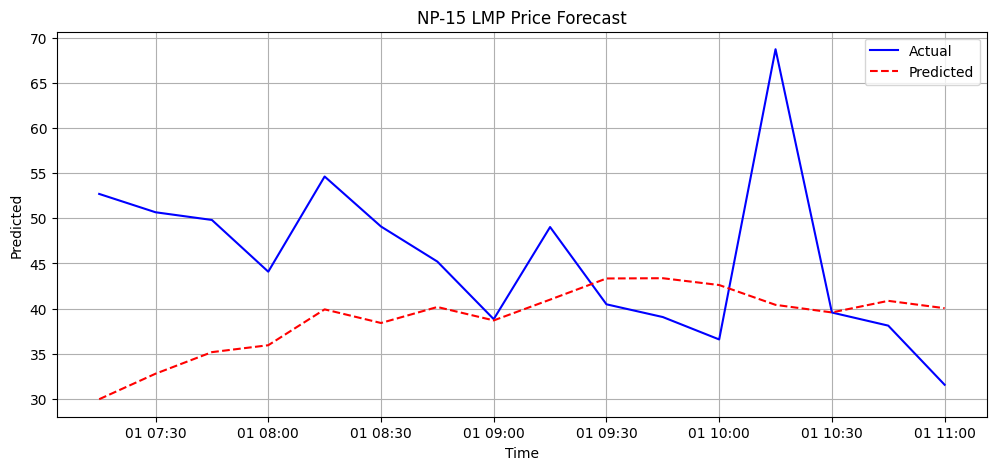

In [11]:
import matplotlib.pyplot as plt

def plot_predictions(zone_name, results_df=final_results.head(50)):
    """Plot actual vs predicted values"""
    zone_data = results_df[results_df['Zone'] == zone_name]

    plt.figure(figsize=(12, 5))
    plt.plot(zone_data['Timestamp'], zone_data['Actual LMP'], 'b-', label='Actual')
    plt.plot(zone_data['Timestamp'], zone_data['Predicted LMP'], 'r--', label='Predicted')
    plt.title(f'{zone_name} Price Forecast')
    plt.xlabel('Time')
    plt.ylabel('Predicted')
    plt.legend()
    plt.grid()
    plt.show()

# Example plot
plot_predictions(zones[1], final_results.head(100))

# Tabulation

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate

# Combine results
final_results = pd.concat(all_results, ignore_index=True)

# Compute metrics
mae = mean_absolute_error(final_results["Actual LMP"], final_results["Predicted LMP"])
rmse = mean_squared_error(final_results["Actual LMP"], final_results["Predicted LMP"])
mape = np.mean(np.abs((final_results["Actual LMP"] - final_results["Predicted LMP"]) / final_results["Actual LMP"])) * 100

# Prepare last 50 rows
last_50 = final_results.tail(20).copy()

# Append a blank row + metrics row for visual separation
metrics_row = {
    "Zone": "Overall Metrics",
    "Timestamp": "",
    "Actual LMP": mae,
    "Predicted LMP": rmse,
    "Error": mape  # we'll label columns below to make this clearer
}
last_50 = pd.concat([last_50, pd.DataFrame([{}, metrics_row])], ignore_index=True)

# Rename for clarity in the metrics row
column_names = {
    "Zone": "Zone",
    "Timestamp": "Timestamp",
    "Actual LMP": "MAE",
    "Predicted LMP": "RMSE",
    "Error": "MAPE (%)"
}

# Display final table
print(tabulate(
    last_50.rename(columns=column_names),
    headers="keys",
    tablefmt="grid",
    floatfmt=".2f",
    showindex=False
))


+-----------------+---------------------+--------+--------+------------+
| Zone            | Timestamp           |    MAE |   RMSE |   MAPE (%) |
+=================+=====================+========+========+============+
| SP-15 LMP       | 2021-04-01 07:15:00 |  50.65 |  75.83 |      25.18 |
+-----------------+---------------------+--------+--------+------------+
| SP-15 LMP       | 2021-04-01 07:30:00 |  48.76 |  78.43 |      29.67 |
+-----------------+---------------------+--------+--------+------------+
| SP-15 LMP       | 2021-04-01 07:45:00 |  48.00 |  77.96 |      29.95 |
+-----------------+---------------------+--------+--------+------------+
| SP-15 LMP       | 2021-04-01 08:00:00 |  46.06 |  77.71 |      31.64 |
+-----------------+---------------------+--------+--------+------------+
| SP-15 LMP       | 2021-04-01 08:15:00 |  51.02 |  80.07 |      29.06 |
+-----------------+---------------------+--------+--------+------------+
| SP-15 LMP       | 2021-04-01 08:30:00 |  46.17 | 